# Part 3 of Topic Modeling for our unseen passages.

Our datasource is from 'https://www.indiacelebrating.com/english-essay/'. There are 367 english essays/passages on this website. We have taken 360 of them as training set and 7 for testing. This dataset was scraped in the last notebook and put into a csv file for future implementations. 

## Tasks to be performed in this notebook

- Import dataset
- Improve stopwords
- Clean data: Tokenize, lemmatize, remove digits, create bigrams and trigrams
- Create a WordCloud to see word frequency
- Implement LdaModel and calculate coherence
- Visualize topic distribution using pyLDAvis
- Improve this model further by getting number of topics
- To avoid getting stopwords into topic estimation use TF-IDF(Term Frequency-Inverse Doc Freq)
- Test best model on test data
- Find topic that has the highest percentage contribution in that document
- Find Most Representative document for each topic
- Topic distribution across documents

In [96]:
from PIL import Image
import requests


In [116]:
def get_img_from_url(link):
    res = requests.get(link, stream=True)
    exe=link.split('.')[-1]
    img_name='img.'+exe
    with open(img_name, 'wb') as f:
        f.write(res.content)
    
    return img_name

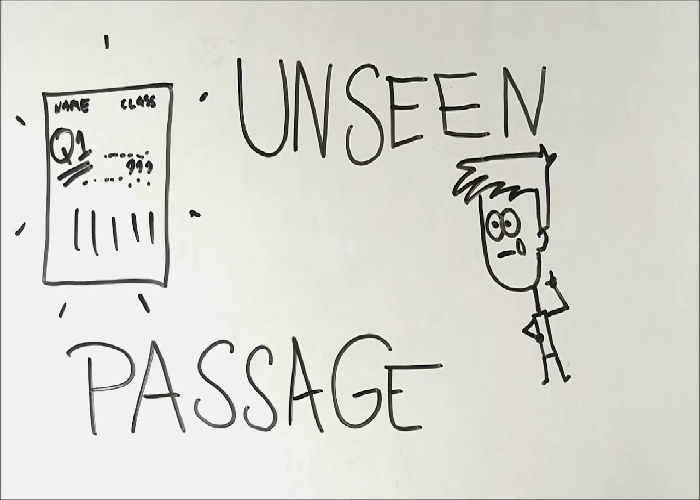

In [117]:
img_name= get_img_from_url("https://i.ytimg.com/vi/KhftMKdUeek/maxresdefault.jpg")
img = Image.open(img_name)
img.resize([700,500])

In [37]:
# Import required packages
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
import logging
import pyLDAvis.gensim
import json

from gensim.models import wrappers, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [5]:
from nltk.corpus import stopwords
from gensim.models import Phrases
from pprint import pprint
from wordcloud import WordCloud

In [6]:
# Import dataset
df = pd.read_csv('Scrapped_data.csv')
df.head()

,Data,Clean_Data,List,bow
0,Generation Gap occurs when there is a consider...,generation gap occurs considerable difference ...,"['generation', 'gap', 'occurs', 'considerable'...","[(0, 2), (1, 1), (2, 1), (3, 3), (4, 3), (5, 1..."
1,Globalization is the process used by businesse...,globalization process used business organizati...,"['globalization', 'process', 'used', 'business...","[(9, 1), (11, 1), (12, 2), (16, 3), (19, 1), (..."
2,Music is the art of expressing ideas and emoti...,music art expressing idea emotion significant ...,"['music', 'art', 'expressing', 'idea', 'emotio...","[(11, 2), (21, 1), (23, 1), (24, 10), (27, 5),..."
3,"Hobby is the favorite activity, habit or choic...",hobby favorite activity habit choice person re...,"['hobby', 'favorite', 'activity', 'habit', 'ch...","[(11, 3), (12, 1), (17, 2), (23, 3), (24, 5), ..."
4,Money is the medium used by people to buy requ...,money medium used people buy required good ser...,"['money', 'medium', 'used', 'people', 'buy', '...","[(17, 1), (20, 1), (21, 2), (38, 1), (40, 4), ..."


In [7]:
stopword_list = stopwords.words('english')
stopword_set = set(stopword_list)
ss={'also', 'used', 'essay', 'right', 'good', 'quiet', 'born', 'often', 'long', 'point', 'process', 'must', 'opinion', 'older', 'thus', 'hence', 'many', 'want', 'cause', 'going'}
stopword_set = stopword_set.union(ss)
len(stopword_set)

199

In [8]:
# Define function for tokenize and lemmatizing
def doc_clean(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    doc_token = tokenizer.tokenize(doc)
    doc_stops = [word.lower().strip() for word in doc_token if word.lower().strip() not in stopword_set]
    no_digit = [word for word in doc_stops if not word.isdigit()]
    len_4 = [word for word in no_digit if len(word)>3]
    lemm = WordNetLemmatizer()
    clean_tokens = [lemm.lemmatize(word) for word in len_4]
    #print(clean_tokens)
    #min_count : Ignore all words and bigrams with total collected count lower than this value.
    bi_gram = Phrases(clean_tokens, min_count=10)
    tri_gram = Phrases(bi_gram[clean_tokens])
    
    for token in bi_gram[clean_tokens]:
        if '_' in token:
            clean_tokens.append(token)
    for token in tri_gram[clean_tokens]:
        if '_' in token:
            clean_tokens.append(token)
    
    return clean_tokens

In [9]:
# Perform function on our document
clean_rows = [doc_clean(row) for row in df['Data']]
#clean_rows[0]

In [10]:
print(len(clean_rows))

360


In [11]:
for l in clean_rows[:10]:
    if 'also' in l:
        print (l)

In [12]:
wc = WordCloud(width=1000, height=800, min_font_size=8, max_words=300, stopwords=stopword_set)

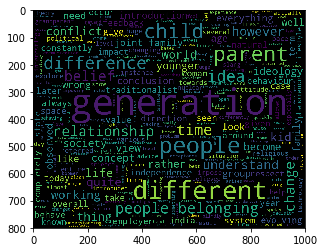

In [13]:
plt.Figure(figsize=(10,8))
plt.imshow(wc.generate_from_text(' '.join(clean_rows[0])))

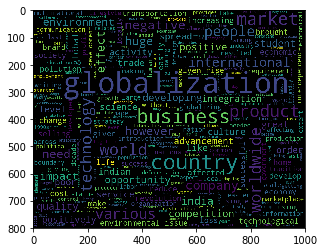

In [14]:
plt.imshow(wc.generate_from_text(' '.join(clean_rows[1])))

Create Biagram & Trigram Models

    bigram = Phraser(phrases)
    sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
    print(bigram[sent]) >>> [u'the', u'mayor', u'of', u'new_york', u'was', u'there']

To get trigrams and so on, we should use the bigram model that we already have and apply Phrases to it again, and so on. 

    Example: trigram_model = Phrases(bigram_sentences)

Remove rare & common tokens. Create a dictionary representation of the documents.

In [15]:
dict_df = Dictionary(clean_rows)
#dict_df.filter_extremes(no_below=20, no_above=0.5)#, keep_n=100000)
doc_bow = [dict_df.doc2bow(doc) for doc in clean_rows]

In [16]:
print('Number of unique tokens: %d' % len(dict_df))
print('Number of documents: %d' % len(doc_bow))
#print(doc_bow[:1])

Number of unique tokens: 14038
Number of documents: 360


In [17]:
print(dict_df[1])
#print(dict_df.id2token)
#id_2word = dict_df.id2token
#print(id_2word)

absolutely


In [18]:
id_2word = dict_df.id2token
len(id_2word)

14038

In [19]:
id_2word[0]

'1960s'

In [20]:
lda = LdaModel(corpus=doc_bow, id2word=dict_df.id2token, num_topics=5, chunksize=500, passes=20, iterations=200, update_every=1)

In [21]:
pprint(lda.print_topics(num_words=7))

[(0,
  '0.020*"india" + 0.019*"country" + 0.015*"people" + 0.010*"woman" + '
  '0.009*"education" + 0.009*"indian" + 0.008*"government"'),
 (1,
  '0.020*"water" + 0.014*"pollution" + 0.010*"earth" + 0.010*"global" + '
  '0.010*"environment" + 0.009*"warming" + 0.009*"natural"'),
 (2,
  '0.025*"life" + 0.016*"time" + 0.012*"people" + 0.011*"help" + '
  '0.010*"health" + 0.008*"sport" + 0.008*"work"'),
 (3,
  '0.015*"people" + 0.012*"india" + 0.012*"family" + 0.010*"country" + '
  '0.007*"child" + 0.007*"love" + 0.007*"indian"'),
 (4,
  '0.016*"school" + 0.012*"friend" + 0.012*"teacher" + 0.011*"student" + '
  '0.010*"time" + 0.009*"life" + 0.006*"mother"')]


#### Topic 0 is a represented as 0.018*"water" + 0.010*"pollution" + 0.010*"life" + 0.009*"earth" + '0.009*"environment".

It means the top 5 keywords that contribute to this topic are: 'water', 'pollution', 'life', 'earth' and 'environment' and the weight of 'water' on topic 0 is 0.018.

The weights reflect how important a keyword is to that topic.
We may summarise topic as either 'water' or 'pollution' or 'earth'. 

In [22]:
print(lda[doc_bow])

LDA is an unsupervised technique, meaning that we don’t know prior to running the model how many topics exits in our corpus. Topic coherence is one of the main techniques used to estimate the number of topics.We will use both UMass and c_v measure to see the coherence score of our LDA model.

In [23]:
coherence = CoherenceModel(model = lda, corpus= doc_bow, dictionary=dict_df, texts=clean_rows)

In [24]:
print(coherence.get_coherence())

0.44186572337571317


In [25]:
print('\nPerplexity: ', lda.log_perplexity(doc_bow))  # a measure of how good the model is. lower the better.


Perplexity:  -7.5734549819590145


Finally much needed improvement.

In [26]:
lda_display = pyLDAvis.gensim.prepare(topic_model=lda, corpus=doc_bow, dictionary=dict_df, sort_topics=False)
pyLDAvis.display(lda_display)
#lda_display

#### Reading the pyLDAvis output 

- Topic 1 look's like the most prevalent topic as it has the largest bubble size.

- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. 

- A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart as we had achieved before.

- The words and bars on the right-hand side will update as we move the curser. These words are the salient keywords that form the selected topic.

Now our aim is to improve this model further

1. We will find the optimal number of topics. For this we need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

2. We will implement Mallet’s version of LDA algorithm


In [21]:
mallet_path = '/mallet-2.0.8/bin/mallet'
#gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
#ldamallet = wrappers.LdaMallet(mallet_path, corpus=doc_bow, num_topics=20, id2word=id_2word)

In [22]:
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
#coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=clean_rows, dictionary=id_2word, coherence='c_v')
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, iterations=500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## RUN BELOW ONCE MALLET ISSUE RESOLVES

def compute_coherence_values_ldamallet(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=wrappers.LdaMallet(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
models, coherences = compute_coherence_values(dictionary=dict_df, corpus=doc_bow, texts=clean_rows, start=2, limit=40, step=6)

In [29]:
# Show graph
limit=40; 
start=2; 
step=6;
x = range(start, limit, step)

In [30]:
print(len(coherences))
print(x)

7
range(2, 40, 6)


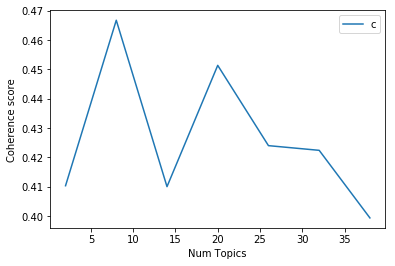

In [31]:
plt.Figure(figsize=(10,8))
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
print(max(coherences))

0.46670884450987127


In [33]:
# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4104
Num Topics = 8  has Coherence Value of 0.4667
Num Topics = 14  has Coherence Value of 0.41
Num Topics = 20  has Coherence Value of 0.4513
Num Topics = 26  has Coherence Value of 0.424
Num Topics = 32  has Coherence Value of 0.4224
Num Topics = 38  has Coherence Value of 0.3994


Number of Topics: 8

In [34]:
coherence = CoherenceModel(model = lda, corpus= doc_bow, dictionary=dict_df, texts=clean_rows)
print(coherence.get_coherence())

0.44186572337571317


In [35]:
# Select the model and print the topics
optimal_model = models[1]
model_topics = optimal_model.show_topics(formatted=False)
#print(model_topics)
pprint(optimal_model.print_topics(num_words=5)[:5])

[(0,
  '0.022*"water" + 0.019*"pollution" + 0.013*"environment" + 0.010*"natural" + '
  '0.010*"resource"'),
 (1,
  '0.028*"life" + 0.024*"time" + 0.012*"friend" + 0.012*"people" + '
  '0.011*"work"'),
 (2,
  '0.015*"life" + 0.012*"family" + 0.012*"time" + 0.010*"love" + '
  '0.009*"people"'),
 (3,
  '0.027*"warming" + 0.027*"global" + 0.013*"earth" + 0.012*"temperature" + '
  '0.011*"change"'),
 (4,
  '0.022*"education" + 0.021*"school" + 0.019*"student" + 0.018*"teacher" + '
  '0.010*"season"')]


## We will try with tf-idf on this model to check if improves

In [45]:
tf = TfidfModel(corpus=doc_bow, id2word=dict_df)
type(tf)

gensim.models.tfidfmodel.TfidfModel

In [51]:
tf_corpus = tf[doc_bow]
type(tf_corpus)

gensim.interfaces.TransformedCorpus

In [67]:
#dict_df.id2token
dict_df

In [66]:
tf_ldamodel=LdaModel(corpus=tf_corpus, id2word=dict_df, num_topics=8, passes=20, iterations=500)

In [49]:
tf_ldamodel.print_topics(num_words=7)

[(0,
  '0.000*"cashless" + 0.000*"baisakhi" + 0.000*"varna" + 0.000*"demonetisation" + 0.000*"jati" + 0.000*"kshatriya" + 0.000*"debendranath"'),
 (1,
  '0.001*"sword" + 0.000*"mightier" + 0.000*"dog" + 0.000*"zoological" + 0.000*"zoo" + 0.000*"captivity" + 0.000*"reptile"'),
 (2,
  '0.001*"elephant" + 0.000*"sankranti" + 0.000*"makar" + 0.000*"teresa" + 0.000*"minar" + 0.000*"trunk" + 0.000*"barney"'),
 (3,
  '0.001*"globalization" + 0.000*"shastri" + 0.000*"agra" + 0.000*"judiciary" + 0.000*"mountaineering" + 0.000*"trek" + 0.000*"trekked"'),
 (4,
  '0.004*"warming" + 0.003*"global" + 0.002*"pollution" + 0.002*"gas" + 0.002*"earth" + 0.002*"temperature" + 0.002*"resource"'),
 (5,
  '0.002*"woman" + 0.001*"water" + 0.001*"education" + 0.001*"india" + 0.001*"mother" + 0.001*"family" + 0.001*"country"'),
 (6,
  '0.000*"privatization" + 0.000*"missile" + 0.000*"abdul" + 0.000*"kalam" + 0.000*"cuttack" + 0.000*"fauj" + 0.000*"padma"'),
 (7,
  '0.000*"glitter" + 0.000*"rome" + 0.000*"dicta

In [68]:
coher = CoherenceModel(model=tf_ldamodel, corpus=tf_corpus, coherence='c_v', texts=clean_rows)

In [69]:
print(coher.get_coherence())

0.43156666590197673


In [70]:
test_df = pd.read_csv('Scrapped_test.csv')
test_df.head()

,Data
0,This is basically a disease that involves abno...
1,Yoga – An ancient form of exercise which evolv...
2,Happiness is something which is difficult to d...
3,"Health refers to a person’s physical, mental a..."
4,"Addiction of anything is bad – be it a drug, a..."


In [71]:
#doc_clean(df['Data'][0])
# Perform function on our document
clean_rows_test = [doc_clean(row) for row in test_df['Data']]

In [72]:
print(len(clean_rows_test))

7


In [73]:
#doc_bow_test = [dict_df.doc2bow(doc) for doc in clean_rows_test]
doc_bow_test = dict_df.doc2bow(clean_rows_test[3])

In [77]:
doc_bow_test_tf=tf[doc_bow_test]
print(len(doc_bow_test_tf))

445


In [78]:
print(len(doc_bow_test))

445


In [79]:
#id_2word = dict_df.id2token
tups= sorted(models[1][doc_bow_test], key=lambda tup: -1*tup[1])
for index, score in tups:    
    print('Score: ', round(score, 3), '  Topics: ',models[1].print_topic(index, topn=5))

Score:  0.548   Topics:  0.022*"health" + 0.018*"sport" + 0.012*"game" + 0.010*"healthy" + 0.010*"life"
Score:  0.245   Topics:  0.028*"life" + 0.024*"time" + 0.012*"friend" + 0.012*"people" + 0.011*"work"
Score:  0.078   Topics:  0.015*"life" + 0.012*"family" + 0.012*"time" + 0.010*"love" + 0.009*"people"
Score:  0.052   Topics:  0.022*"education" + 0.021*"school" + 0.019*"student" + 0.018*"teacher" + 0.010*"season"
Score:  0.036   Topics:  0.029*"india" + 0.025*"country" + 0.015*"people" + 0.013*"woman" + 0.012*"indian"
Score:  0.03   Topics:  0.022*"people" + 0.013*"festival" + 0.012*"road" + 0.010*"india" + 0.007*"country"
Score:  0.011   Topics:  0.022*"water" + 0.019*"pollution" + 0.013*"environment" + 0.010*"natural" + 0.010*"resource"


In [83]:
tups= sorted(tf_ldamodel[doc_bow_test_tf], key=lambda tup: -1*tup[1])
for index, score in tups:    
    print('Score: ', round(score, 3), '  Topics: ',tf_ldamodel.print_topic(index, topn=5))

Score:  0.932   Topics:  0.002*"pollution" + 0.002*"woman" + 0.002*"water" + 0.002*"warming" + 0.001*"education"


In [82]:
test_df['Data'][3][:200]

'Health refers to a person’s physical, mental and social well being. A person is said to be enjoying good health when he is devoid of any physical ailments, mental stress and enjoys good interpersonal '

#### The theme of this passage is around health and our model with bow corpus was able to predicted that. So we did gain something in this notebook.

Pat on the back shall we!

In [123]:
def display_gif(fn):
    from IPython import display
    return display.HTML("<img src={}/>".format(fn))

In [126]:
img= get_img_from_url("https://media.tenor.com/images/dcfb75f3e33aab070eb8e8116ed594fe/tenor.gif")
display_gif(img)

## Find topic that has the highest percentage contribution in that document

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [127]:
def format_topics_sentences(text, lda_model=lda, corpus=doc_bow):           
    # Init output
    essay_topics_df=pd.DataFrame()
    
    # lda_model takes one doc corpus at a time
    for bow_per_doc in corpus:
        tups= sorted(lda_model[bow_per_doc], key=lambda tup: -1*tup[1])
        for j, (index, score) in enumerate(tups):                
            if j == 0: # Dominant Topic
                #essay_topics_df.loc[j, 'Score']=round(score,4)
                #essay_topics_df.loc[j, 'Dominant_Topic']=lda_model.show_topic(index)[0][0] + ' / '+ str(index)
                #essay_topics_df.loc[j, 'Topic_Keywords']=', '.join([w for w, p in lda_model.show_topic(index)])
                score = round(score,4)
                dom_topic = lda_model.show_topic(index)[0][0] 
                dom_topic_num = str(index)
                topic_list = ', '.join([w for w, p in lda_model.show_topic(index)])
                
                essay_topics_df = essay_topics_df.append(pd.Series([score, dom_topic, dom_topic_num, topic_list]), ignore_index=True)
            #essay_topics_df.loc[j, 'Text']=text[j]
            else:
                break
    essay_topics_df.columns = ['Score', 'Dominant_Topic', 'Dominant_Topic_number', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(text)
    new_df = pd.concat([essay_topics_df, contents], axis=1)
    return new_df

In [128]:
topic_per_doc = format_topics_sentences(df['Data'], models[1], corpus = doc_bow)

In [129]:
# Format
topic_per_doc_df = topic_per_doc.reset_index()
topic_per_doc_df.columns = ['Document_No', 'Score', 'Dominant_Topic', 'Dominant_Topic_number', 'Topic_Keywords', 'Text']

In [139]:
topic_per_doc_df.head()

,Document_No,Score,Dominant_Topic,Dominant_Topic_number,Topic_Keywords,Text
0,0,0.6422,life,2,"life, family, time, love, people, mother, chil...",Generation Gap occurs when there is a consider...
1,1,0.6739,water,0,"water, pollution, environment, natural, resour...",Globalization is the process used by businesse...
2,2,0.7464,life,1,"life, time, friend, people, work, help, need, ...",Music is the art of expressing ideas and emoti...
3,3,0.4444,life,2,"life, family, time, love, people, mother, chil...","Hobby is the favorite activity, habit or choic..."
4,4,0.8018,life,1,"life, time, friend, people, work, help, need, ...",Money is the medium used by people to buy requ...


In [131]:
lda_display = pyLDAvis.gensim.prepare(topic_model=models[1], corpus=doc_bow, dictionary=dict_df, sort_topics=False)
pyLDAvis.display(lda_display)

## Find Most Representative document for each topic

In [132]:
best_matched_doc_topic_df = topic_per_doc_df.groupby(by='Dominant_Topic_number').max()

In [133]:
# d has 8 ros, 1 for each topic and the most representative document
best_matched_doc_topic_df

,Document_No,Score,Dominant_Topic,Topic_Keywords,Text
Dominant_Topic_number,,,,,
0,353,0.9992,water,"water, pollution, environment, natural, resour...",We all understand the term man. It is a famili...
1,359,0.9991,life,"life, time, friend, people, work, help, need, ...",‘Work is Worship’ is a proverb that refers to ...
2,335,0.9992,life,"life, family, time, love, people, mother, chil...","“Necessity is the mother of invention”, a well..."
3,294,0.9990,warming,"warming, global, earth, temperature, change, g...",There is a need to seriously follow all the pr...
4,349,0.9992,education,"education, school, student, teacher, season, l...",We have provided variety of essay on winter se...
5,330,0.9996,india,"india, country, people, woman, indian, governm...",World Environment Day is an annual campaign ru...
6,357,0.9995,health,"health, sport, game, healthy, life, physical, ...",‘Laughter is the best medicine’ the phrase say...
7,358,0.9994,people,"people, festival, road, india, country, world,...",“Unity in Diversity” is a phrase implying unit...


## Topic distribution across documents

calculating the number of documents belonging to a particular topic or contribution of topic to the corpus.

In [134]:
# Number of Documents for Each Topic
count_docs = topic_per_doc_df['Dominant_Topic_number'].value_counts()

In [135]:
# Topic Number and Keywords
topic_distrib = topic_per_doc_df[['Dominant_Topic_number', 'Topic_Keywords']].groupby('Dominant_Topic_number').max()
topic_contribution = round(count_docs/count_docs.sum(),4)

In [136]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_distrib, count_docs, topic_contribution], axis=1)

In [137]:
# Change Column names
df_dominant= df_dominant_topics.reset_index()
df_dominant.columns = ['Dominant_Topic_number', 'Topic_Keywords', 'Number_Documents', 'Percentage_Documents']

# Show
df_dominant

,Dominant_Topic_number,Topic_Keywords,Number_Documents,Percentage_Documents
0,0,"water, pollution, environment, natural, resour...",64,0.1778
1,1,"life, time, friend, people, work, help, need, ...",40,0.1111
2,2,"life, family, time, love, people, mother, chil...",60,0.1667
3,3,"warming, global, earth, temperature, change, g...",21,0.0583
4,4,"education, school, student, teacher, season, l...",36,0.1000
5,5,"india, country, people, woman, indian, governm...",79,0.2194
6,6,"health, sport, game, healthy, life, physical, ...",29,0.0806
7,7,"people, festival, road, india, country, world,...",31,0.0861
